# Notebook 1: Data Loading, Cleaning, Feature Engineering, and EDA

In this notebook i have:
- Loaded `historical_data.csv` and `fear_greed_index.csv`
- Cleaned and standardized schemas
- Engineered daily KPIs
- Merged daily metrics with sentiment
- Produced exploratory analysis charts saved to `outputs/figures/`
- Saved processed datasets to `outputs/data/`


In [8]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (12, 6)

BASE_DIR = "/Users/kumarabhishek/Desktop/Assignment_task/ds_abhishek"
DATA_DIR = os.path.join(BASE_DIR, "csv_files")
OUT_FIG = os.path.join(BASE_DIR, "outputs", "figures")
OUT_DATA = os.path.join(BASE_DIR, "outputs", "data")

os.makedirs(OUT_FIG, exist_ok=True)
os.makedirs(OUT_DATA, exist_ok=True)

def billions(x, pos):
    return f"{x/1e9:.1f}B"

def millions(x, pos):
    return f"{x/1e6:.1f}M"


In [9]:
#loading data
fg_path = os.path.join(DATA_DIR, "fear_greed_index.csv")
trades_path = os.path.join(DATA_DIR, "historical_data.csv")

fg = pd.read_csv(fg_path)
trades_raw = pd.read_csv(trades_path)

print("Fear & Greed shape:", fg.shape)
print("Trades shape:", trades_raw.shape)

fg.head(3), trades_raw.head(3)


Fear & Greed shape: (2644, 4)
Trades shape: (211224, 16)


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 1         0.0  0xec09451986a18

In [10]:
#Cleaning and standardizing the data
trades = trades_raw.copy()
trades.columns = (
    trades.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("/", "_", regex=False)
)
expected_cols = [
    "account", "coin", "execution_price", "size_tokens", "size_usd", "side",
    "timestamp_ist", "start_position", "direction", "closed_pnl", "fee", "timestamp"
]
missing_cols = [c for c in expected_cols if c not in trades.columns]
if missing_cols:
    print("Warning: missing columns:", missing_cols)

for col in ["execution_price", "size_tokens", "size_usd", "closed_pnl", "fee"]:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors="coerce")

if "timestamp_ist" in trades.columns:
    trades["timestamp_ist"] = pd.to_datetime(trades["timestamp_ist"], format="%d-%m-%Y %H:%M", errors="coerce")
elif "timestamp" in trades.columns:
    trades["timestamp_ist"] = pd.to_datetime(trades["timestamp"], errors="coerce")

trades["date"] = trades["timestamp_ist"].dt.date
trades["date"] = pd.to_datetime(trades["date"])  # normalize to midnight

trades["is_buy"] = trades["side"].str.upper().eq("BUY")
trades["is_sell"] = trades["side"].str.upper().eq("SELL")

trades["trade_value_usd"] = trades["size_usd"]
trades["pnl_usd"] = trades.get("closed_pnl", pd.Series(index=trades.index, dtype=float))
trades["fee_usd"] = trades.get("fee", pd.Series(index=trades.index, dtype=float))
trades["net_pnl_usd"] = trades["pnl_usd"].fillna(0) - trades["fee_usd"].fillna(0)

if "leverage" in trades.columns:
    trades["leverage"] = pd.to_numeric(trades["leverage"], errors="coerce")
else:
    trades["leverage"] = np.nan

trades.head(5)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,trade_id,timestamp,date,is_buy,is_sell,trade_value_usd,pnl_usd,fee_usd,net_pnl_usd,leverage
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,...,8.950000e+14,1.730000e+12,2024-12-02,True,False,7872.16,0.0,0.345404,-0.345404,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,...,4.430000e+14,1.730000e+12,2024-12-02,True,False,127.68,0.0,0.005600,-0.005600,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,...,6.600000e+14,1.730000e+12,2024-12-02,True,False,1150.63,0.0,0.050431,-0.050431,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,...,1.080000e+15,1.730000e+12,2024-12-02,True,False,1142.04,0.0,0.050043,-0.050043,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,...,1.050000e+15,1.730000e+12,2024-12-02,True,False,69.75,0.0,0.003055,-0.003055,NaN


In [11]:
agg_funcs = {
    "trade_value_usd": "sum",
    "size_usd": "sum",
    "size_tokens": "sum",
    "execution_price": "mean",
    "fee_usd": "sum",
    "pnl_usd": "sum",
    "net_pnl_usd": "sum",
    "leverage": "mean",
}

buy_volume = trades.groupby("date")["size_usd"].apply(lambda s: s[trades.loc[s.index, "is_buy"]].sum()).rename("buy_volume_usd")
sell_volume = trades.groupby("date")["size_usd"].apply(lambda s: s[trades.loc[s.index, "is_sell"]].sum()).rename("sell_volume_usd")

daily = (
    trades
    .groupby("date")
    .agg(agg_funcs)
    .rename(columns={
        "trade_value_usd": "total_trade_value_usd",
        "size_usd": "total_volume_usd",
        "size_tokens": "total_volume_tokens",
        "execution_price": "avg_execution_price",
        "fee_usd": "total_fees_usd",
        "pnl_usd": "total_pnl_usd",
        "net_pnl_usd": "total_net_pnl_usd",
        "leverage": "avg_leverage",
    })
)

counts = trades.groupby("date").agg(
    num_trades=("account", "size"),
    num_accounts=("account", pd.Series.nunique),
    num_coins=("coin", pd.Series.nunique),
)

daily = (
    daily
    .join(buy_volume, how="left")
    .join(sell_volume, how="left")
    .join(counts, how="left")
)

daily["buy_sell_ratio"] = daily["buy_volume_usd"].fillna(0) / daily["sell_volume_usd"].replace(0, np.nan)

daily.reset_index(inplace=True)
daily.head()


,date,total_trade_value_usd,total_volume_usd,total_volume_tokens,avg_execution_price,total_fees_usd,total_pnl_usd,total_net_pnl_usd,avg_leverage,buy_volume_usd,sell_volume_usd,num_trades,num_accounts,num_coins,buy_sell_ratio
0,2023-05-01,477.00,477.00,0.25130,1898.133333,0.000000,0.000000,0.000000,NaN,477.00,0.00,3,1,1,NaN
1,2023-12-05,50005.83,50005.83,11.80901,11038.300000,12.501455,0.000000,-12.501455,NaN,25007.21,24998.62,9,1,2,1.000344
2,2023-12-14,113203.35,113203.35,4092.28901,8031.868818,28.300831,-205.434737,-233.735568,NaN,51407.47,61795.88,11,1,4,0.831892
3,2023-12-15,10609.95,10609.95,3558.00000,2.982000,2.652489,-24.632034,-27.284523,NaN,10609.95,0.00,2,1,1,NaN
4,2023-12-16,15348.77,15348.77,39897.00000,0.384707,3.837189,0.000000,-3.837189,NaN,15348.77,0.00,3,1,1,NaN


In [12]:
# Prepare fear & greed index
if "date" in fg.columns:
    fg["date"] = pd.to_datetime(fg["date"], errors="coerce")
else:
    if "timestamp" in fg.columns:
        fg["date"] = pd.to_datetime(fg["timestamp"], unit="s", errors="coerce").dt.normalize()

if "value" in fg.columns:
    fg.rename(columns={"value": "fg_value"}, inplace=True)
fg_use = fg[[c for c in ["date", "fg_value", "classification"] if c in fg.columns]].dropna(subset=["date"])
merged = pd.merge(daily, fg_use, on="date", how="left")

print("Merged shape:", merged.shape)
merged.head(5)


Merged shape: (480, 17)


,date,total_trade_value_usd,total_volume_usd,total_volume_tokens,avg_execution_price,total_fees_usd,total_pnl_usd,total_net_pnl_usd,avg_leverage,buy_volume_usd,sell_volume_usd,num_trades,num_accounts,num_coins,buy_sell_ratio,fg_value,classification
0,2023-05-01,477.00,477.00,0.25130,1898.133333,0.000000,0.000000,0.000000,NaN,477.00,0.00,3,1,1,NaN,63.0,Greed
1,2023-12-05,50005.83,50005.83,11.80901,11038.300000,12.501455,0.000000,-12.501455,NaN,25007.21,24998.62,9,1,2,1.000344,75.0,Extreme Greed
2,2023-12-14,113203.35,113203.35,4092.28901,8031.868818,28.300831,-205.434737,-233.735568,NaN,51407.47,61795.88,11,1,4,0.831892,72.0,Greed
3,2023-12-15,10609.95,10609.95,3558.00000,2.982000,2.652489,-24.632034,-27.284523,NaN,10609.95,0.00,2,1,1,NaN,70.0,Greed
4,2023-12-16,15348.77,15348.77,39897.00000,0.384707,3.837189,0.000000,-3.837189,NaN,15348.77,0.00,3,1,1,NaN,67.0,Greed


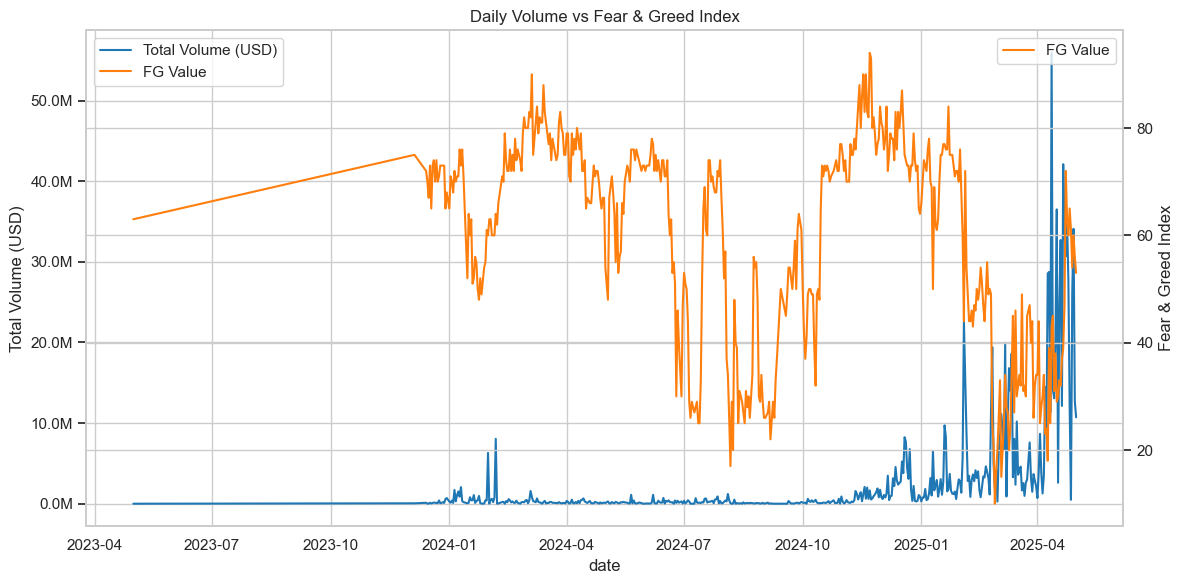

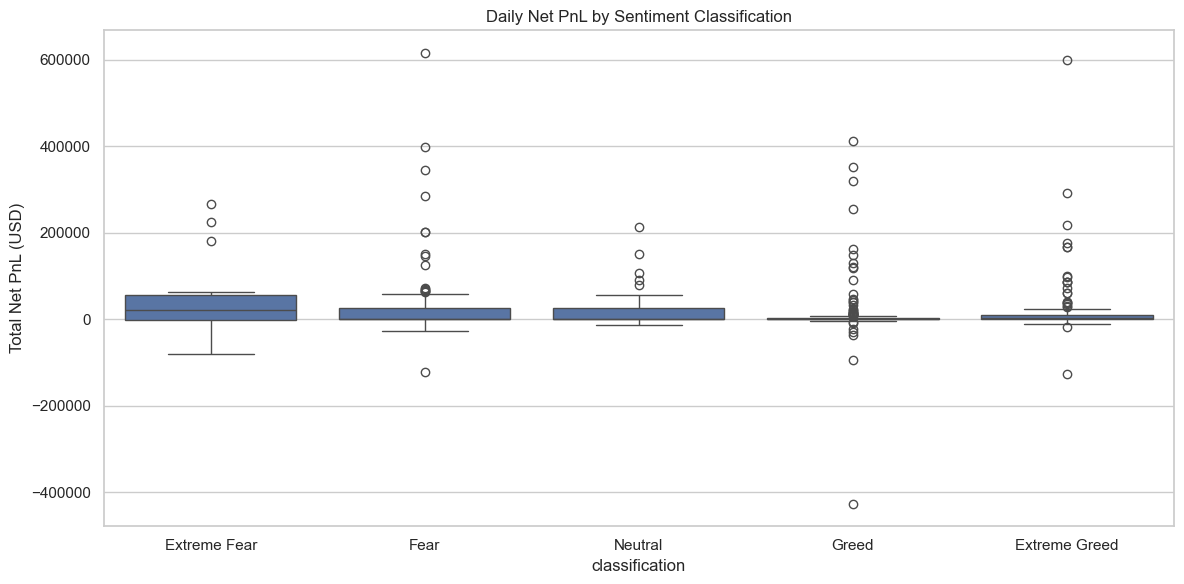

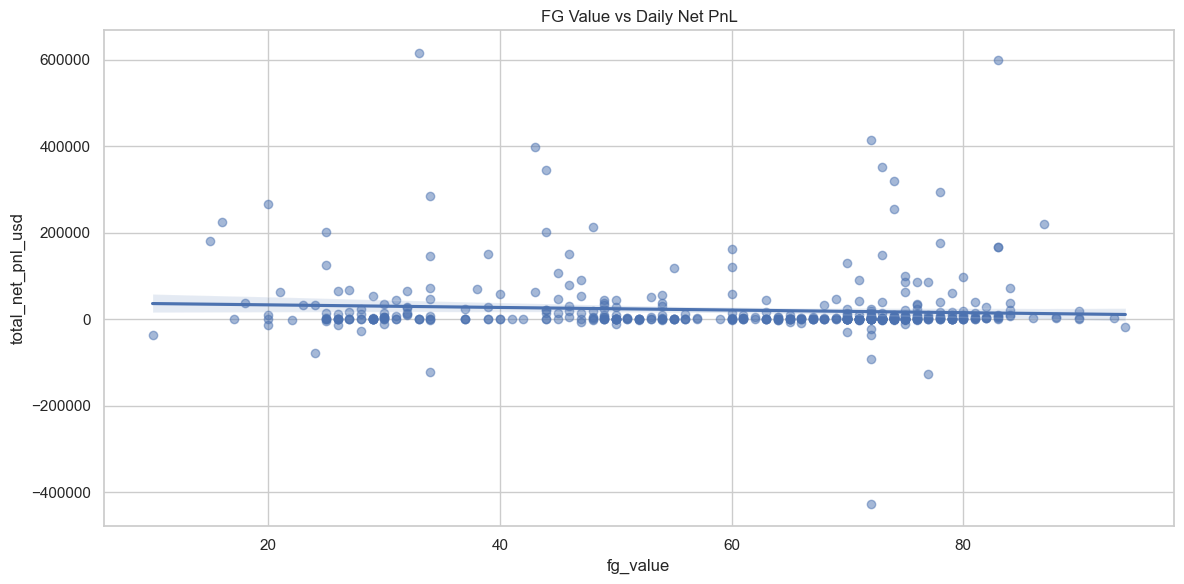

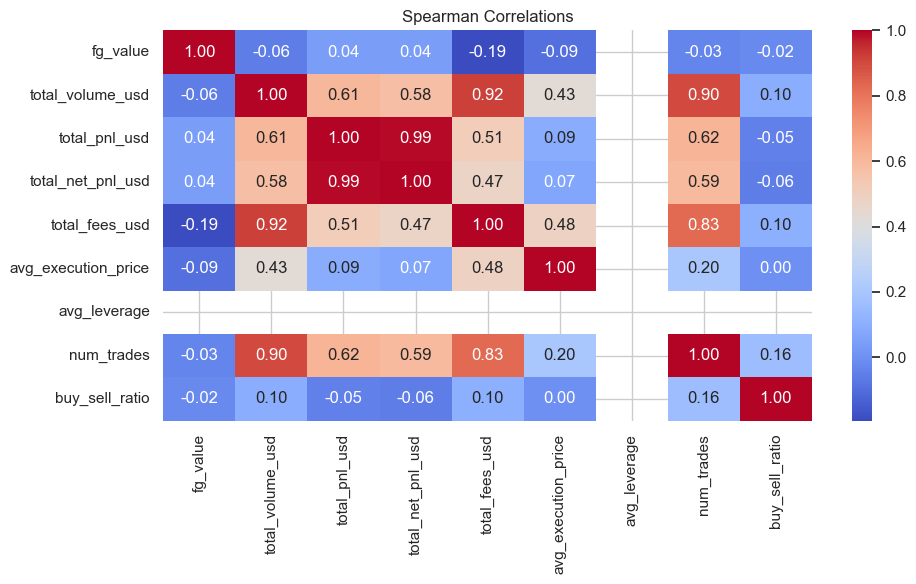

In [13]:
# EDA:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(data=merged, x="date", y="total_volume_usd", ax=ax1, color="#1f77b4", label="Total Volume (USD)")
sns.lineplot(data=merged, x="date", y="fg_value", ax=ax2, color="#ff7f0e", label="FG Value")

ax1.set_ylabel("Total Volume (USD)")
ax1.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.set_ylabel("Fear & Greed Index")
ax1.set_title("Daily Volume vs Fear & Greed Index")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")
plt.tight_layout()
fig.savefig(os.path.join(OUT_FIG, "timeseries_volume_vs_fg.png"), dpi=200)
plt.show()

if "classification" in merged.columns:
    plt.figure()
    sns.boxplot(data=merged.dropna(subset=["classification"]), x="classification", y="total_net_pnl_usd", order=["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"])
    plt.title("Daily Net PnL by Sentiment Classification")
    plt.ylabel("Total Net PnL (USD)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_FIG, "boxplot_netpnl_by_classification.png"), dpi=200)
    plt.show()

plt.figure()
sns.regplot(data=merged, x="fg_value", y="total_net_pnl_usd", scatter_kws={"alpha": 0.5})
plt.title("FG Value vs Daily Net PnL")
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG, "scatter_fg_vs_netpnl.png"), dpi=200)
plt.show()

corr_cols = [c for c in [
    "fg_value", "total_volume_usd", "total_pnl_usd", "total_net_pnl_usd", "total_fees_usd",
    "avg_execution_price", "avg_leverage", "num_trades", "buy_sell_ratio"
] if c in merged.columns]

corr = merged[corr_cols].corr(method="spearman")
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False)
plt.title("Spearman Correlations")
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG, "corr_heatmap.png"), dpi=200)
plt.show()


In [14]:
# Save processed data
merged.to_csv(os.path.join(OUT_DATA, "daily_metrics_with_sentiment.csv"), index=False)
daily.to_csv(os.path.join(OUT_DATA, "daily_metrics.csv"), index=False)
print("Saved:",
      os.path.join(OUT_DATA, "daily_metrics_with_sentiment.csv"),
      os.path.join(OUT_DATA, "daily_metrics.csv"))


Saved: /Users/kumarabhishek/Desktop/Assignment_task/ds_abhishek/outputs/data/daily_metrics_with_sentiment.csv /Users/kumarabhishek/Desktop/Assignment_task/ds_abhishek/outputs/data/daily_metrics.csv
